# Öpik-frame b-plane for Earth–(99942) Apophis Encounter 2029

In this notebook we
1. convert the provided heliocentric orbital elements to heliocentric state vectors,
2. build the Earth-centered hyperbola, compute $\mathbf u_\infty^-$, construct an Öpik frame, and compute the $b$-plane coordinates $(\xi,\zeta)$,
3. plot the b-plane point and Earth’s gravitationally-focused collision cross section,
4. add Valsecchi circles, i.e. contours of post-encounter semimajor axis $a^+$ corresponding to chosen resonant returns.

Note: this is an **exercise** and not a validated Apophis 2029 keyhole product.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, atan2, sqrt

# ---- Constants ----
mu_sun   = 1.32712440018e11   # km^3/s^2
mu_earth = 398600.4418        # km^3/s^2
R_earth  = 6378.137           # km
deg2rad  = np.pi/180.0
au2km = 149597870.7

# ---- Orbital elements (from screenshot) + mean anomalies (rad) ----
#2462237.500000000 = A.D. 2029-Apr-11 00:00:00.0000 TDB 
# Earth
a1 = 9.973091572352096E-01*au2km
e1 = 1.838896295295013E-02
i1 = 4.329826068186278E-03*deg2rad
w1 = 3.061443121940218E+02 *deg2rad
O1 = 1.512071301280637E+02*deg2rad
M1 = 1.016491301017181E+02*deg2rad

# Apophis
a2 = 9.190965593865476E-01*au2km
e2 = 1.929348335924014E-01
i2 = (3.367770080090324E+00)*deg2rad
w2 = 1.274886235983452E+02*deg2rad
O2 = 2.038495014776776E+02*deg2rad
M2 = 2.484530662165266E+02*deg2rad


**Define Helper Functions**

In [2]:
def solve_kepler(M, e, tol=1e-12, maxiter=200):
    """Solve Kepler: M = E - e sin E for E (elliptic)."""
    E = M if e < 0.8 else np.pi
    for _ in range(maxiter):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        dE = -f/fp
        E += dE
        if abs(dE) < tol:
            break
    return E

def R3(a):
    """Rotation about z axis"""
    c, s = np.cos(a), np.sin(a)
    return np.array([[c,-s,0],[s,c,0],[0,0,1]])

def R1(a):
    """Rotation about x axis"""
    c, s = np.cos(a), np.sin(a)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]])

def elements_to_state(a, e, i, Om, w, M, mu=mu_sun):
    """ Transform Keplerian Orbital Elements to rv states.
    Only works for elliptic orbits!
    
    input: 
        a... semimajor axis [distance units]
        e... eccentricity 0<= e <1
        i... inclination [rad]
        Om.. RAAN [rad]
        w... argument of pericenter [rad]
        mu.. Gravitational parameter

    output:
        r_vec ... state vector [distance units]
        v_vec ... velocity vector [distance units / time units]
    
    """
    E = solve_kepler(M, e)
    f = 2*atan2(sqrt(1+e)*sin(E/2), sqrt(1-e)*cos(E/2))
    r = a*(1 - e*np.cos(E))
    p = a*(1 - e*e)
    r_pqw = np.array([r*np.cos(f), r*np.sin(f), 0.0])
    v_pqw = np.sqrt(mu/p) * np.array([-np.sin(f), e+np.cos(f), 0.0])
    Q = R3(Om) @ R1(i) @ R3(w)

    r_vec = Q@r_pqw
    v_vec = Q@v_pqw
    return r_vec, v_vec 

def vecRot3D(x, y, delta):
    """Euler-Rodriguez rotation of vector x about vector y by angle delta [rad]"""
    yhat = y/np.linalg.norm(y)
    return x*np.cos(delta)+np.cross(yhat,x)*np.sin(delta)+yhat*np.dot(yhat,x)*(1.0 - np.cos(delta))

TWOPI = 2.0 * np.pi

def _wrap2pi(x: float) -> float:
    """Angle wrapping function, ensures angle x [rad] is in [0, 2pi)"""
    return x % TWOPI

def rv_to_kepler(r, v, mu, t_epoch=None, tol=1e-12):
    """
    Convert heliocentric (or any central-body) Cartesian state vectors to
    classical Keplerian orbital elements.

    Parameters
    ----------
    r : array_like, shape (3,)
        Position vector [length]
    v : array_like, shape (3,)
        Velocity vector [length/time]
    mu : float
        Gravitational parameter of central body [length^3/time^2]
    t_epoch : float or None
        If provided, interpreted as the time corresponding to (r,v) [T].
        Then time of periapsis passage tp is returned in the same time units.
  
    tol : float
        Tolerance used to detect near-circular / near-equatorial cases

    Returns
    -------
    oe : dict
        {
          'a'    : semimajor axis (can be negative for hyperbola) [length]
          'e'    : eccentricity (>=0)
          'i'    : inclination [rad]
          'raan' : right ascension of ascending node Ω [rad]
          'argp' : argument of periapsis ω [rad]
          'nu'   : true anomaly ν [rad]
          'p'    : semi-latus rectum p [length]
          'anomaly_type': anomaly_type, hyperbolic, parabolic or elliptic
          'E_or_H_or_D': eccentric, hyperbolic or parabolic anomaly
          'M': mean anomaly
          "n": mean_motion
          "dt_since_tp": time since pericenter passage
          "tp": time of pericenter passage tp
          'h_vec'    : h specific angular momentum vector [length^2/time]
          'e_vec'    : eccentricity vector
        }

    Notes
    -----
    - Handles ellipse/hyperbola robustly. Parabolic (e≈1) returns a≈inf.
    - For singular cases:
        * near-equatorial (i~0): raan is set to 0 and argp is measured from +x axis (longitude of periapsis).
        * near-circular (e~0): argp is set to 0 and nu becomes argument of latitude (or true longitude if also equatorial).
    """
    r = np.asarray(r, dtype=float).reshape(3)
    v = np.asarray(v, dtype=float).reshape(3)
    mu = float(mu)

    rnorm = np.linalg.norm(r)
    vnorm = np.linalg.norm(v)

    # Specific angular momentum
    h_vec = np.cross(r, v)
    h = np.linalg.norm(h_vec)

    # Inclination
    i = np.arccos(np.clip(h_vec[2] / h, -1.0, 1.0))

    # Node vector (pointing to ascending node)
    k_hat = np.array([0.0, 0.0, 1.0])
    n_vec = np.cross(k_hat, h_vec)
    n = np.linalg.norm(n_vec)

    # Eccentricity vector
    e_vec = (np.cross(v, h_vec) / mu) - (r / rnorm)
    e = np.linalg.norm(e_vec)

    # Specific orbital energy
    eps = 0.5 * vnorm**2 - mu / rnorm

    # Semi-major axis (parabolic -> inf)
    if abs(e - 1.0) < 1e-10:
        a = np.inf
    else:
        a = -mu / (2.0 * eps)

    # Semi-latus rectum
    p = h**2 / mu

    # RAAN Ω
    if n > tol:
        raan = np.arctan2(n_vec[1], n_vec[0]) % (2.0 * np.pi)
    else:
        raan = 0.0  # equatorial

    # Argument of periapsis ω and true anomaly ν with singular-case handling
    if e > tol and n > tol:
        # general case
        argp = np.arctan2(
            np.dot(np.cross(n_vec, e_vec), h_vec) / (n * e * h),
            np.dot(n_vec, e_vec) / (n * e),
        ) % (2.0 * np.pi)

        nu = np.arctan2(
            np.dot(np.cross(e_vec, r), h_vec) / (e * rnorm * h),
            np.dot(e_vec, r) / (e * rnorm),
        ) % (2.0 * np.pi)

    elif e <= tol and n > tol:
        # circular, inclined: argp undefined -> set to 0, nu -> argument of latitude u
        argp = 0.0
        # u = angle from node to position
        nu = np.arctan2(
            np.dot(np.cross(n_vec, r), h_vec) / (n * rnorm * h),
            np.dot(n_vec, r) / (n * rnorm),
        ) % (2.0 * np.pi)

    elif e > tol and n <= tol:
        # equatorial, non-circular: raan undefined -> set to 0, argp -> longitude of periapsis varpi
        raan = 0.0
        # varpi = angle from +x to periapsis
        argp = np.arctan2(e_vec[1], e_vec[0]) % (2.0 * np.pi)
        # nu measured from periapsis in equatorial plane
        nu = np.arctan2(
            np.dot(np.cross(e_vec, r), h_vec) / (e * rnorm * h),
            np.dot(e_vec, r) / (e * rnorm),
        ) % (2.0 * np.pi)

    else:
        # circular and equatorial: only true longitude defined
        raan = 0.0
        argp = 0.0
        nu = np.arctan2(r[1], r[0]) % (2.0 * np.pi)


# ---------------- Anomalies + time of periapsis ----------------
    anomaly_type = None
    EHD = None
    M = None
    mean_motion = None
    dt_since_tp = None
    tp = None

    # Decide conic type from e (most robust for anomaly logic)
    if e < 1.0 - 1e-10:
        # Ellipse
        anomaly_type = "elliptic"
        # E from nu (works for e=0 too)
        sin_half = np.sin(nu / 2.0)
        cos_half = np.cos(nu / 2.0)
        E = 2.0 * np.atan2(np.sqrt(1.0 - e) * sin_half,
                             np.sqrt(1.0 + e) * cos_half)
        E = _wrap2pi(E)
        EHD = E
        M = _wrap2pi(E - e * np.sin(E))

        mean_motion = np.sqrt(mu / (a ** 3))  # [rad/T]
        dt_since_tp = M / mean_motion          # [T] (wrapped, 0..P)
        if t_epoch is not None:
            tp = float(t_epoch) - dt_since_tp

    elif e > 1.0 + 1e-10:
        # Hyperbola
        anomaly_type = "hyperbolic"
        # H from nu via tanh(H/2) relation
        tan_half_nu = np.tan(nu / 2.0)
        gamma = np.sqrt((e - 1.0) / (e + 1.0))
        x = gamma * tan_half_nu
        # atanh(x) requires |x|<1; for hyperbola this holds for |nu|<pi.
        # If nu is wrapped to [0,2pi), map it to (-pi,pi] for consistency.
        nu_signed = nu
        if nu_signed > np.pi:
            nu_signed -= TWOPI
        tan_half_nu = np.tan(nu_signed / 2.0)
        x = gamma * tan_half_nu

        # Numerical safety: allow tiny overshoot
        if abs(x) >= 1.0:
            x = np.sign(1.0 - 1e-15, x)

        H = 2.0 * np.atanh(x)
        EHD = H
        Mh = e * np.sinh(H) - H   # hyperbolic mean anomaly (unwrapped real)
        M = Mh

        mean_motion = np.sqrt(mu / ((-a) ** 3))  # positive scalar [rad/T]
        dt_since_tp = Mh / mean_motion             # can be negative/positive
        if t_epoch is not None:
            tp = float(t_epoch) - dt_since_tp

    else:
        # Parabola (near-e=1): use Barker
        anomaly_type = "parabolic"
        # Barker variable D = tan(nu/2), use signed nu in (-pi, pi]
        nu_signed = nu
        if nu_signed > np.pi:
            nu_signed -= TWOPI
        D = np.tan(nu_signed / 2.0)
        EHD = D
        M = None
        mean_motion = None

        # Time since periapsis from Barker:
        #   t - tp = sqrt(p^3/(2*mu)) * (D + D^3/3)
        dt_since_tp = np.sqrt((p ** 3) / (2.0 * mu)) * (D + (D ** 3) / 3.0)
        if t_epoch is not None:
            tp = float(t_epoch) - dt_since_tp
    
    return {
        "a": a,
        "e": e,
        "i": np.rad2deg(i),
        "raan": np.rad2deg(raan),
        "argp": np.rad2deg(argp),
        "nu": nu,
        "p": p,
        "anomaly_type": anomaly_type,
        "E_or_H_or_D": np.rad2deg(EHD),
        "M": np.rad2deg(M),
        "n": mean_motion,
        "dt_since_tp": dt_since_tp,
        "tp": tp,
        "h_vec": h_vec,
        "e_vec":e_vec
    }




**Calculate b-plane coordinates in Öpik frame**

In [3]:
# Heliocentric states
rE, vE = elements_to_state(a1, e1, i1, O1, w1, M1)
rA, vA = elements_to_state(a2, e2, i2, O2, w2, M2)

# Earth-centered relative state
rho = rA - rE
u   = vA - vE
rho_n = np.linalg.norm(rho)
u_n   = np.linalg.norm(u)

energy = 0.5*u_n**2 - mu_earth/rho_n
v_inf  = np.sqrt(2*energy)

h_vec  = np.cross(rho, u)
h      = np.linalg.norm(h_vec)

# Earth-centered hyperbola eccentricity vector
e_h = np.cross(u, h_vec)/mu_earth - rho/rho_n
e   = np.linalg.norm(e_h)

# Hyperbola perifocal triad
p_hat = e_h / e
h_hat = h_vec / h
q_hat = np.cross(h_hat, p_hat)

# asymptote true anomaly
f_inf = np.arccos(-1.0/e)

# Incoming asymptotic velocity in inertial coordinates
p_val = h*h/mu_earth
u_inf_pqw = np.sqrt(mu_earth/p_val) * np.array([np.sin(f_inf), e + np.cos(f_inf), 0.0])
u_inf_minus = u_inf_pqw[0]*p_hat + u_inf_pqw[1]*q_hat

assert np.allclose(np.linalg.norm(u_inf_minus), v_inf, rtol=0, atol=1e-8)

delta = 2*np.asin(1./e)
u_inf_plus = vecRot3D(u_inf_minus, h_hat, delta)

assert np.allclose(np.linalg.norm(u_inf_plus), v_inf, rtol=0, atol=1e-8)

r_p = h*h/mu_earth/(1+e) 
v_plus = vE + u_inf_plus


# Öpik frame: eta along incoming asymptote, and (xi,zeta) spanning b-plane
eta_hat = u_inf_minus / v_inf
k_hat = np.cross(rE, vE)
k_hat = k_hat / np.linalg.norm(k_hat)
xi_hat = np.cross(k_hat, eta_hat)
xi_hat = xi_hat / np.linalg.norm(xi_hat)
zeta_hat = np.cross(eta_hat, xi_hat)

# Impact parameter vector (correct identity): b = (u_inf x h)/|u_inf|^2
b_vec = np.cross(u_inf_minus, h_vec) / (v_inf**2)
b = np.linalg.norm(b_vec)

# b-plane coordinates
xi   = np.dot(b_vec, xi_hat)
zeta = np.dot(b_vec, zeta_hat)

# gravitational focusing collision cross section
b_coll = R_earth * np.sqrt(1.0 + 2.0*mu_earth/(R_earth * v_inf**2))
sigma_coll = np.pi * b_coll**2


r_plus = rA
oe = rv_to_kepler(r_plus, v_plus, mu_sun, t_epoch=None)


In [4]:
print('rA, vA', rA,vA)
print('rE, vE', rE,vE)

# Earth - centered Encounter state
print('Earth centered encounter state')
print('rho [km]=', rho)
print('u [km/s]=',u)
print('engergy=',energy)
print('h_vec=',h_vec)
print('eccentricity vector=', e_h)
print('eccentricity=', e)
print('v_inf [km/s]=', v_inf)
print('p_hat =',p_hat)
print('h_hat =',h_hat)
print('q_hat =',q_hat)

# asymptote true anomaly
print('f_inf = ',f_inf)
print('delta = ',delta)
print('u_inf^- =',u_inf_minus)
print('u_inf^+ =',u_inf_plus)
print('r_p [km]=',r_p )

# b-plane coordinates
print('b [km]=', b)
print('(xi, zeta) [km]=', xi, zeta)

# gravitational focusing
print('b_coll [km]=', b_coll)
print('sigma_coll [km^2]=', sigma_coll)

#pre/post encounter quantities
print('v^- =',vA)
print('v^+ =',v_plus)
print('r^- = r^+ =',rA)
print('h^+ = r x v^+ =', oe['h_vec'])
print('ecc^+ = 1/mu_sun(v^+ x h^+) - r/||r||) =', oe['e_vec'])
#print('energy^+ = 1/2(||v^+||^2 - mu_sun/||r||) =', v_inf/np.sqrt(2))
print('a^+ [au]=',oe['a']/au2km)
print('e^+ =',oe['e'])
print('i^+ =',oe['i'])
print('w^+ =',oe['argp'])
print('Om^+ =',oe['raan'])
print('M =',oe['M'])

rA, vA [-1.40901273e+08 -5.47514702e+07 -4.05753810e+05] [ 14.37640672 -24.10948891   1.63967955]
rE, vE [-1.39796888e+08 -5.38153784e+07  8.65231142e+03] [ 1.01724873e+01 -2.79086251e+01  1.47804277e-03]
Earth centered encounter state
rho [km]= [-1104384.51476634  -936091.75947197  -414406.12119902]
u [km/s]= [4.20391945 3.79913615 1.63820151]
engergy= 17.13034265830902
h_vec= [  40878.34249175   67074.42966351 -260452.78724217]
eccentricity vector= [-2.02470988  3.53654843  0.59298726]
eccentricity= 4.1180406477244835
v_inf [km/s]= 5.853262792376405
p_hat = [-0.49166826  0.85879396  0.14399743]
h_hat = [ 0.15026602  0.24656106 -0.95740679]
q_hat = [0.85771933 0.44908861 0.25027379]
f_inf =  1.816082488869574
delta =  0.4905723241493545
u_inf^- = [4.17134077 3.77061775 1.62574391]
u_inf^+ = [5.56902661 1.32928841 1.21639642]
r_p [km]= 36276.34322686753
b [km]= 46476.61409877024
(xi, zeta) [km]= 46319.445180544375 3818.986285986463
b_coll [km]= 13751.05279843559
sigma_coll [km^2]= 5940

**Compare to actual post-encounter orbital elements**

In [5]:
# Apophis, heliocentric osculating orbital elements post encounter
# 2462241.500000000 = A.D. 2029-Apr-15 00:00:00.0000 TDB 
# EC= 1.910700206507544E-01 QR= 8.918558059552598E-01 IN= 2.266087226596090E+00
# OM= 2.036722165112792E+02 W = 7.190308420860877E+01 Tp=  2462301.332809137646
# N = 8.519609433769777E-01 MA= 3.090247834823328E+02 TA= 2.894256982870430E+02
# A = 1.102512984711885E+00 AD= 1.313170163468509E+00 PR= 4.225545816373256E+02


**Visualize b-plane coordinates**

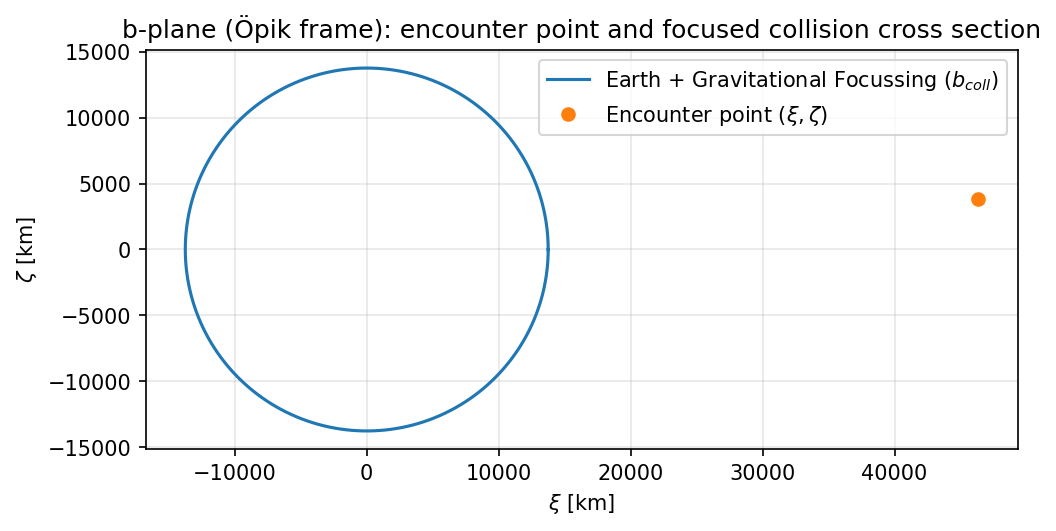

In [6]:
# ---- Plot: b-plane point + focused collision circle ----
fig = plt.figure(figsize=(7.5, 7.0), dpi=150)
ax = fig.add_subplot(111)

th = np.linspace(0, 2*np.pi, 600)
ax.plot(b_coll*np.cos(th), b_coll*np.sin(th), label=r'Earth + Gravitational Focussing ($b_{coll}$)')
ax.plot([xi], [zeta], 'o', label=r'Encounter point $(\xi,\zeta)$')

ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\xi$ [km]')
ax.set_ylabel(r'$\zeta$ [km]')
ax.set_title('b-plane (Öpik frame): encounter point and focused collision cross section')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


## Valsecchi resonance circles on the b-plane

Valsecchi et al. show that, for fixed post-encounter direction parameter $\theta'$, the solution set in the $(\xi,\zeta)$ b-plane is a **circle**
with center on the $\zeta$ axis. For a given target $\theta'_\ast$:

$$
\xi^2 + (\zeta - D)^2 = R^2,
$$
with
$$
c = \frac{\mu_\oplus}{v_\infty^2},\qquad
D = \frac{c\,\sin\theta}{\cos\theta'_\ast - \cos\theta},\qquad
R = \frac{c\,\sin\theta'_\ast}{\cos\theta'_\ast - \cos\theta}.
$$

Here $\theta$ is the incoming direction angle of $\mathbf u_\infty^-$ measured in a local heliocentric frame with $\hat{\mathbf y}$ along Earth's heliocentric velocity.

To associate a resonance $p{:}q$ with a circle, we compute $a_{res}=a_E (p/q)^{2/3}$ and solve for the corresponding $\theta'_\ast$ using a local circular approximation at the encounter radius $r=\|\mathbf r_E\|$.


In [7]:
# ---- Local heliocentric encounter frame for Valsecchi angles (X,Y,Z) ----
# Choose Y along Earth's heliocentric velocity; X radial; Z completes RH triad.
r_hat = rE / np.linalg.norm(rE)
v_hat_raw = vE / np.linalg.norm(vE)

# Make y_hat orthogonal to r_hat (tangential direction)
y_hat = v_hat_raw - np.dot(v_hat_raw, r_hat)*r_hat
y_hat = y_hat / np.linalg.norm(y_hat)
z_hat = np.cross(r_hat, y_hat)
z_hat = z_hat / np.linalg.norm(z_hat)
x_hat = r_hat

# Incoming asymptote components in this frame
Ux = np.dot(u_inf_minus, x_hat)
Uy = np.dot(u_inf_minus, y_hat)
Uz = np.dot(u_inf_minus, z_hat)
U  = np.linalg.norm(u_inf_minus)

# Valsecchi angles: Uy = U cos(theta); Ux = U sin(theta) sin(phi); Uz = U sin(theta) cos(phi)
theta = np.arccos(np.clip(Uy/U, -1.0, 1.0))
phi   = np.arctan2(Ux, Uz)

c = mu_earth / (v_inf**2)  # gravitational radius (km)

print('theta [deg]=', theta/deg2rad)
print('phi   [deg]=', phi/deg2rad)
print('c [km]=', c)


theta [deg]= 110.19079281543281
phi   [deg]= -72.78195979027285
c [km]= 11634.339421887165


In [8]:
def theta_prime_for_resonance(p, q):
    """Compute theta'_star for resonance p:q using local circular approximation at r=||rE||."""
    r = np.linalg.norm(rE)
    v_c = np.sqrt(mu_sun / r)
    U = v_inf / v_c
    a_res = a1 * (p/q)**(2/3)
    v_res2 = mu_sun*(2.0/r - 1.0/a_res)
    cos_thp = (v_res2/(v_c*v_c) - 1.0 - U*U)/(2.0*U)
    return a_res, cos_thp

def valsecchi_circle_params(theta, theta_p, c):
    denom = (np.cos(theta_p) - np.cos(theta))
    D = c*np.sin(theta)/denom
    R = c*np.sin(theta_p)/denom
    return D, R

res_list = [(7,6), (6,5), (5,4), (4,3), (3,2), (2,1)]
circle_data = []
for (p,q) in res_list:
    a_res, cos_thp = theta_prime_for_resonance(p,q)
    if abs(cos_thp) <= 1.0:
        thp = np.arccos(cos_thp)
        D, R = valsecchi_circle_params(theta, thp, c)
        circle_data.append((p,q,a_res,thp,D,R))
    else:
        circle_data.append((p,q,a_res,np.nan,np.nan,np.nan))

for p,q,a_res,thp,D,R in circle_data:
    if np.isfinite(thp):
        print(f"{p}:{q}  a_res={a_res:.3e} km  theta'={thp/deg2rad:.3f} deg  D={D:.3e} km  R={R:.3e} km")
    else:
        print(f"{p}:{q}  a_res={a_res:.3e} km  (no real theta' from approximation)")


7:6  a_res=1.653e+08 km  theta'=81.910 deg  D=2.247e+04 km  R=2.371e+04 km
6:5  a_res=1.685e+08 km  theta'=79.421 deg  D=2.065e+04 km  R=2.163e+04 km
5:4  a_res=1.731e+08 km  theta'=75.860 deg  D=1.853e+04 km  R=1.914e+04 km
4:3  a_res=1.807e+08 km  theta'=70.310 deg  D=1.601e+04 km  R=1.606e+04 km
3:2  a_res=1.955e+08 km  theta'=60.259 deg  D=1.298e+04 km  R=1.201e+04 km
2:1  a_res=2.368e+08 km  theta'=33.273 deg  D=9.244e+03 km  R=5.404e+03 km


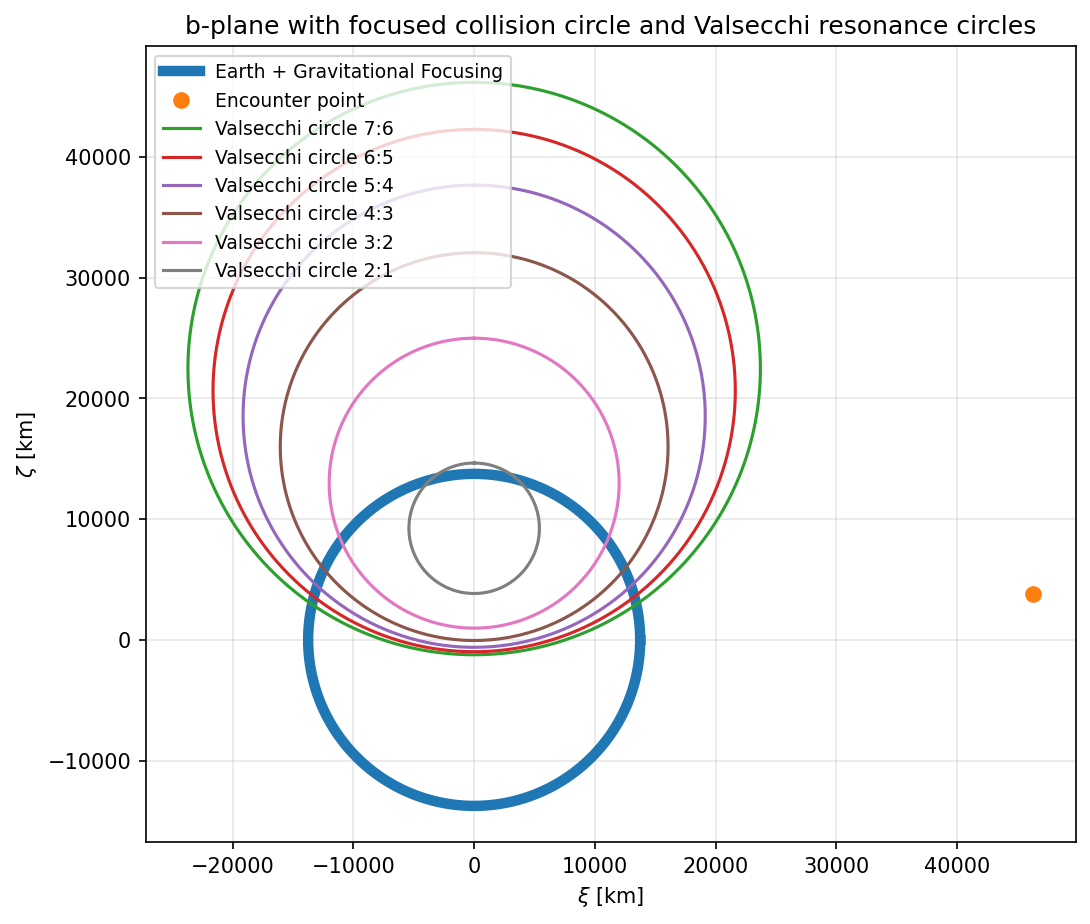

In [9]:
# ---- Plot b-plane with focused collision circle + Valsecchi circles ----
fig = plt.figure(figsize=(8.0, 7.2), dpi=150)
ax = fig.add_subplot(111)

th = np.linspace(0, 2*np.pi, 1000)

# Focused collision circle at origin
ax.plot(b_coll*np.cos(th), b_coll*np.sin(th), linewidth=5.0, label=r'Earth + Gravitational Focusing')
    
# Encounter point
ax.plot([xi], [zeta], 'o', markersize=7, label='Encounter point')

# Valsecchi circles
for (p,q,a_res,thp,D,R) in circle_data:
    if not np.isfinite(R):
        continue
    xi_c = R*np.sin(th)
    ze_c = D + R*np.cos(th)
    ax.plot(xi_c, ze_c, linewidth=1.5, label=f"Valsecchi circle {p}:{q}")
    #circ=plt.Circle((0,D), R, linewidth=1.5, fill=False, label=f"Valsecchi circle {p}:{q}")
    #ax.add_patch(circ)

ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\xi$ [km]')
ax.set_ylabel(r'$\zeta$ [km]')
ax.set_title('b-plane with focused collision circle and Valsecchi resonance circles')
ax.grid(True, alpha=0.3)

# Center plot on encounter point so circles are visible
pad = 2.5e5
#ax.set_xlim(xi - pad, xi + pad)
#ax.set_ylim(zeta - pad, zeta + pad)

ax.legend(loc='upper left', fontsize=9)
plt.show()


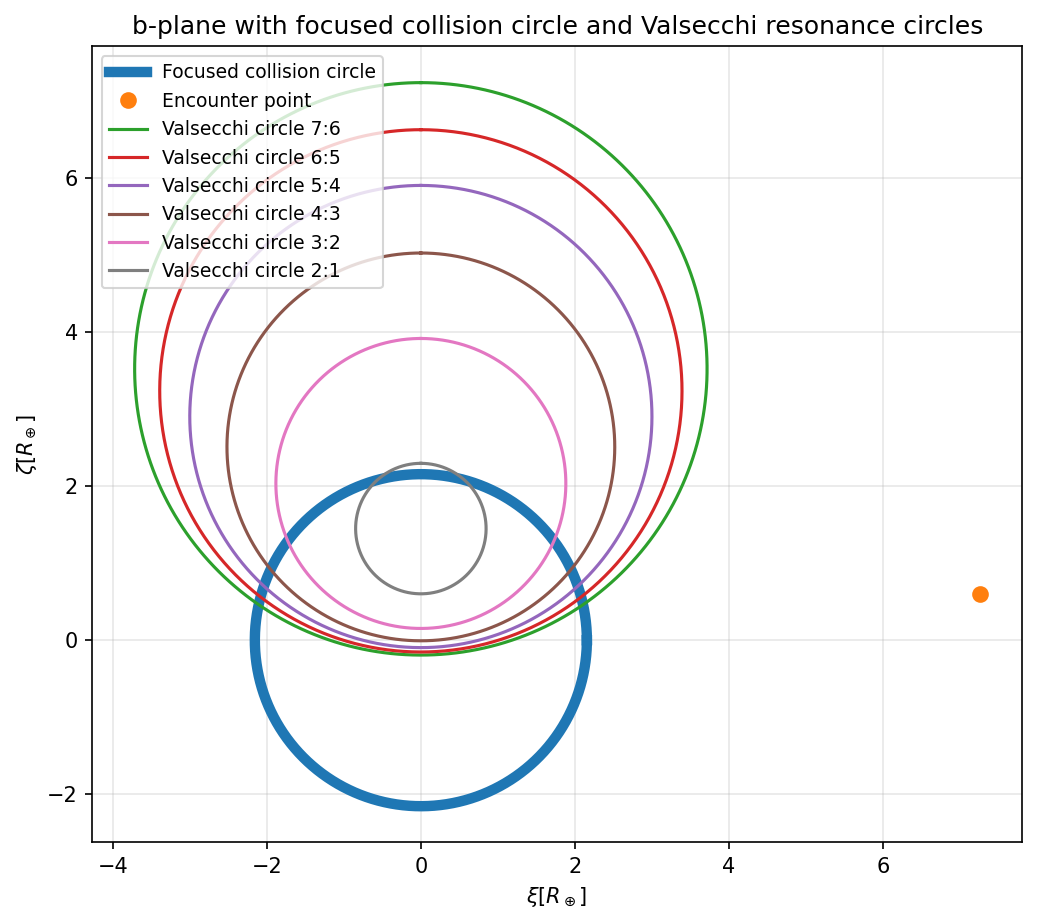

In [10]:
# ---- Plot b-plane with focused collision circle + Valsecchi circles ----
fig = plt.figure(figsize=(8.0, 7.2), dpi=150)
ax = fig.add_subplot(111)

th = np.linspace(0, 2*np.pi, 1000)

b_coll_e = b_coll/R_earth

# Focused collision circle at origin
ax.plot(b_coll_e*np.cos(th), b_coll_e*np.sin(th), linewidth=5.0, label=r'Focused collision circle')
    
# Encounter point
ax.plot([xi/R_earth], [zeta/R_earth], 'o', markersize=7, label='Encounter point')

# Valsecchi circles
for (p,q,a_res,thp,D,R) in circle_data:
    if not np.isfinite(R):
        continue
    xi_c = R*np.sin(th)
    ze_c = D + R*np.cos(th)
    ax.plot(xi_c/R_earth, ze_c/R_earth, linewidth=1.5, label=f"Valsecchi circle {p}:{q}")
    #circ=plt.Circle((0,D), R, linewidth=1.5, fill=False, label=f"Valsecchi circle {p}:{q}")
    #ax.add_patch(circ)

ax.set_aspect('equal', 'box')
ax.set_xlabel(r'$\xi [R_\oplus]$ ')
ax.set_ylabel(r'$\zeta [R_\oplus]$')
ax.set_title('b-plane with focused collision circle and Valsecchi resonance circles')
ax.grid(True, alpha=0.3)

# Center plot on encounter point so circles are visible
pad = 2.5e5
#ax.set_xlim(xi - pad, xi + pad)
#ax.set_ylim(zeta - pad, zeta + pad)

ax.legend(loc='upper left', fontsize=9)
plt.show()